# ODEFormer experiment using SIR model

## Imports

In [1]:
from data_generation import ode_solver
from odeformer_utils import get_odeformer_model, plot_actual_vs_estimated_trajectory
import numpy as np
import matplotlib.pyplot as plt
from odeformer.metrics import r2_score, mean_squared_error

In [2]:
beam_size = 150
beam_temperature = 0.1

## Parameters of SIR model

In [3]:
days = 365
# Population size
init_S, init_I, init_R = 100, 2, 0
initial_conditions = [init_S, init_I, init_R]
# Population proportions
N = init_S + init_I + init_R
init_S_prop, init_I_prop, init_R_prop = init_S / N, init_I / N, init_R / N  
initial_conditions_prop = [init_S_prop, init_I_prop, init_R_prop]    
# Transmission and recovery rate
beta, gamma = 0.3, 0.1
times = np.arange(0, days, 1)

In [4]:
# Solution when using population size
sol = ode_solver(initial_conditions, times, beta, gamma, proportion=False)
S, I, R = sol.T
trajectory = np.stack([S, I, R], axis=1)

In [5]:
# Solution when using proportion
sol_prop = ode_solver(initial_conditions_prop, times, beta, gamma, proportion=True)
S_prop, I_prop, R_prop = sol_prop.T
trajectory_prop = np.stack([S_prop, I_prop, R_prop], axis=1)

## Determine the symbolic representation

### Raw population size model

In [6]:
# Load the pre-trained model

# class Params:
#     def __init__(self):
#         self.init_scale = N
#         self.time_range = days

# params = Params()
# Adding the params to the dstr object results in an additional ODE being generated?

dstr = get_odeformer_model(beam_temperature=beam_temperature, beam_size=beam_size)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [7]:
# Fit the model to the trajectory data for population size
candidates = dstr.fit(times, trajectory)
dstr.print(n_predictions=1) # Return the best symbolic expression - increase to see other candidates

x_0' = -0.0425 * x_0
x_1' = 0.2836 * x_1 + -0.0074 * x_1 * (0.4312 * x_2 + 0.8930 * x_1)
x_2' = 0.1246 * x_1 + -0.0033 * x_0


The estimated SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -0.0425 S \\
    \frac{dI}{dt} &= 0.2836 I - 0.0074 I \times (0.4312 R + 0.8930 I)\\
    \\
    &= 0.2547 I - 0.00661 I^2 - 0.00319 IR \\
    \frac{dR}{dt} &= 0.1246 I + -0.0033 S
\end{align*}

The true SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -\frac{\beta}{N}IS \\
    \frac{dI}{dt} &= \frac{\beta}{N}IS - \gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align*}
where $\beta=0.3$, $N=102$, and $\gamma=0.1$. Therefore $\frac{\beta}{N} \approx 0.002941$.

In [8]:
# Predict the trajectory using the initial conditions and the fitted model (best candidate)
pred_trajectory = dstr.predict(times, trajectory[0])
print(r2_score(trajectory, pred_trajectory))
print(mean_squared_error(trajectory, pred_trajectory))

0.8691620085004951
45.67371772242666


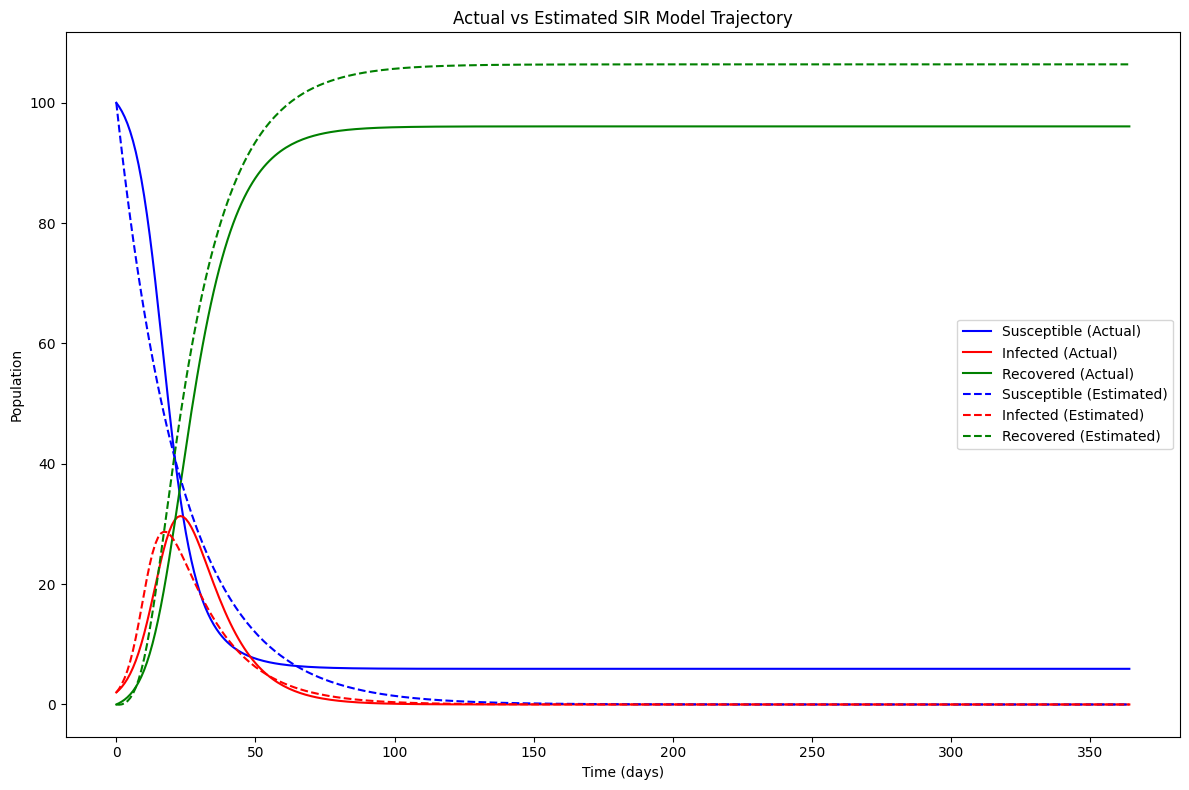

In [9]:
fig = plot_actual_vs_estimated_trajectory(times, trajectory, pred_trajectory)
fig.show()

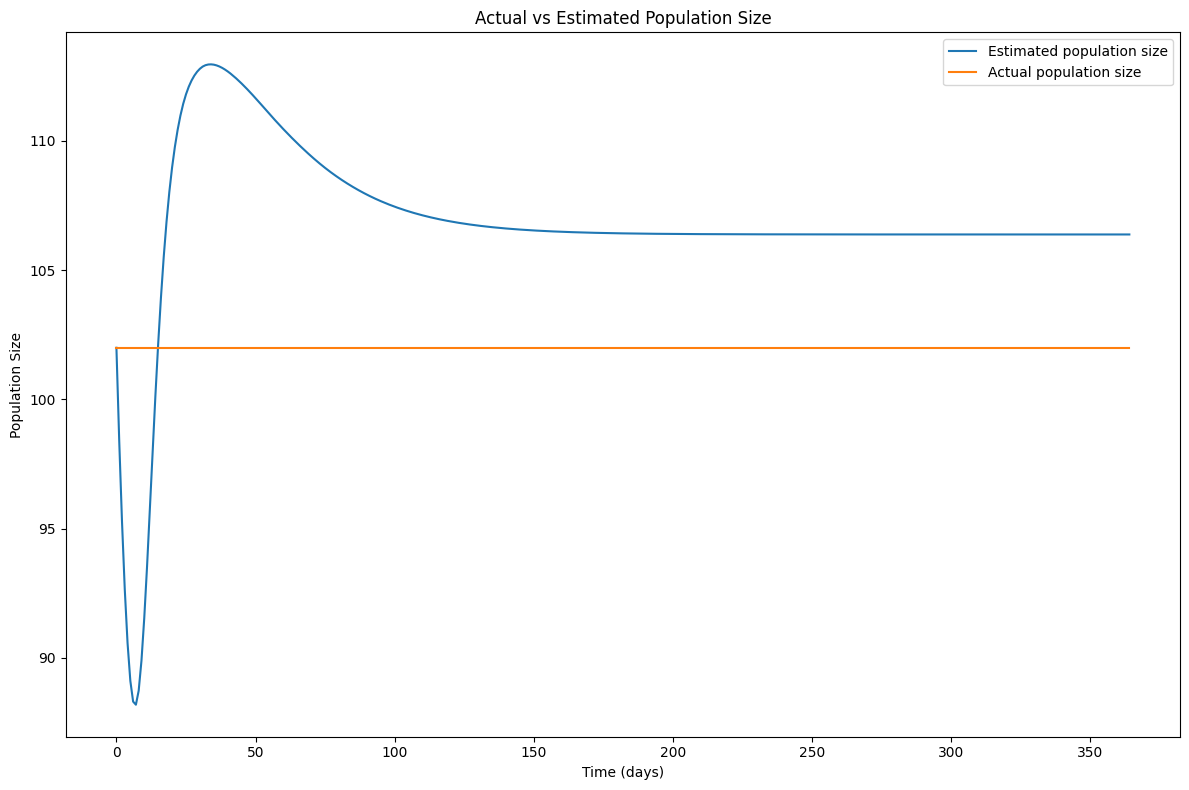

In [10]:
# Check if the total population is conserved
plt.figure(figsize=(12, 8))
plt.plot(times, np.sum(pred_trajectory, axis=1), label='Estimated population size')
plt.plot(times, np.sum(trajectory, axis=1), label='Actual population size')
plt.xlabel('Time (days)')
plt.ylabel('Population Size')
plt.title('Actual vs Estimated Population Size')
plt.legend()
plt.tight_layout()
plt.show()

### Proportion SIR model

In [11]:
# Retry using proportion=True

# Load the pre-trained model
# class Params:
#     def __init__(self):
#         self.init_scale = 1
#         self.time_range = days

# params = Params()

dstr_prop = get_odeformer_model(beam_temperature=beam_temperature, beam_size=beam_size)


Found pretrained model at odeformer.pt
Loaded pretrained model


In [12]:
# Fit the model to the trajectory data for population proportion
candidates = dstr_prop.fit(times, trajectory_prop)
dstr_prop.print(n_predictions=1) # Return the best symbolic expression - increase to see other candidates

x_0' = -1.2914 * x_1 * (x_0)**2
x_1' = 0.0005 * x_0 + -0.0013 * x_1 + -0.4411 * x_1 * (0.3590 * x_2 + -0.7206 * x_0)
x_2' = 1.5586 * x_1 + -13.4152 * x_0 * x_1 * x_2


The estimated SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -1.2914 I  S^2 \\
    \frac{dI}{dt} &= 0.0005 S - 0.0013 I - 0.4411 I \times (0.3590 R - 0.7206 S)\\
    \frac{dR}{dt} &= 1.5586 I - 13.4152 SIR
\end{align*}

The true SIR model equations are:
\begin{align*} 
    \frac{dS}{dt} &= -\beta IS \\
    \frac{dI}{dt} &= \beta IS - \gamma I\\
    \frac{dR}{dt} &= \gamma I
\end{align*}
where $\beta=0.3$, and $\gamma=0.1$.


In [13]:
# Predict the trajectory using the initial conditions and the fitted model (best candidate)
pred_trajectory_prop = dstr_prop.predict(times, trajectory_prop[0])
print(r2_score(trajectory_prop, pred_trajectory_prop))
print(mean_squared_error(trajectory_prop, pred_trajectory_prop))

0.7799207075946585
0.006084208140806228


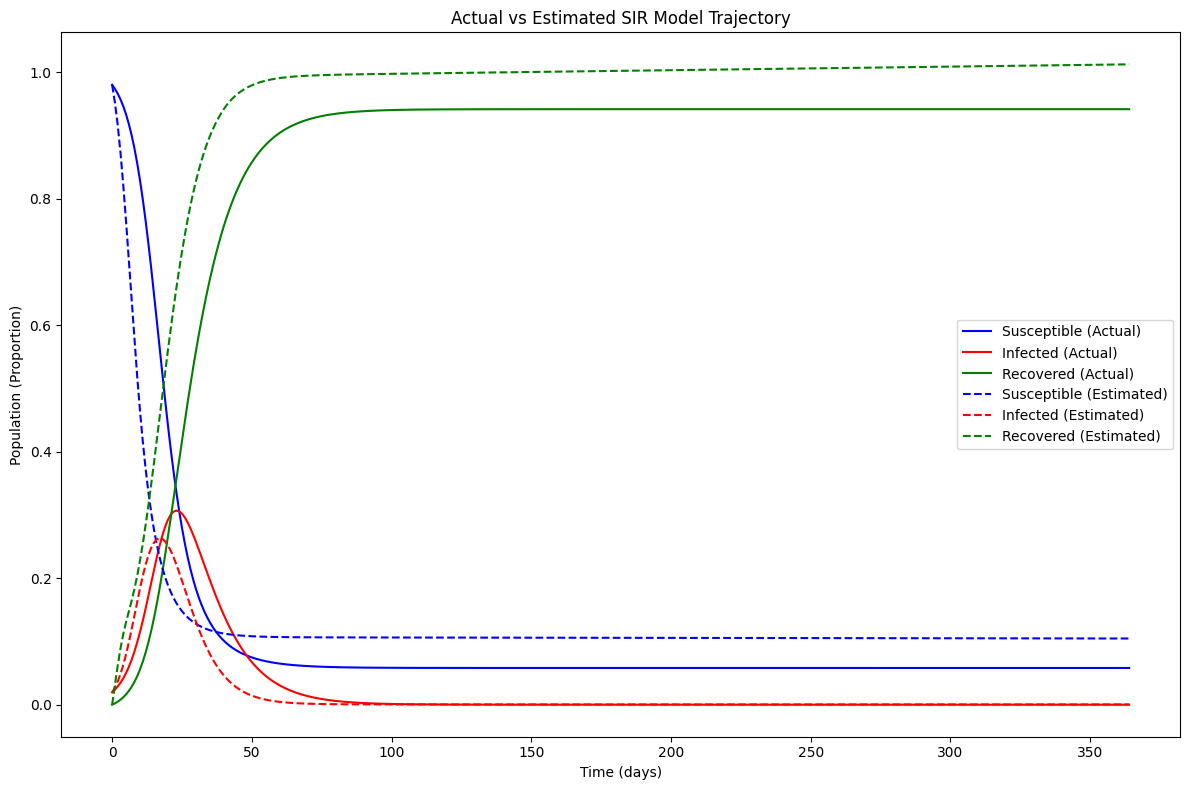

In [14]:
fig = plot_actual_vs_estimated_trajectory(times, trajectory_prop, pred_trajectory_prop, ylabel='Population (Proportion)',)
fig.show()

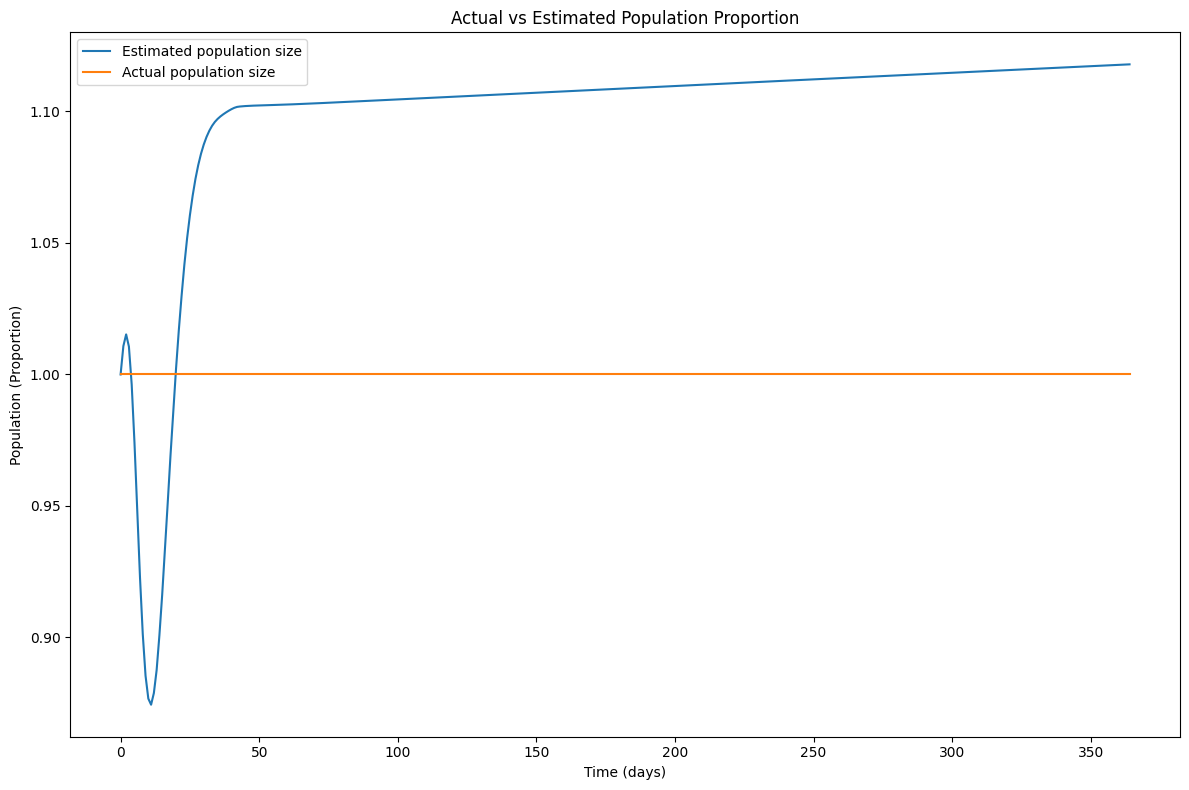

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(times, np.sum(pred_trajectory_prop, axis=1), label='Estimated population size')
plt.plot(times, np.sum(trajectory_prop, axis=1), label='Actual population size')
plt.xlabel('Time (days)')
plt.ylabel('Population (Proportion)')
plt.title('Actual vs Estimated Population Proportion')
plt.legend()
plt.tight_layout()
plt.show()